# LSTM anomaly detection (UPDATED)

This updated notebook includes recommended fixes for class imbalance: **class_weight**, **threshold tuning**, **Precision-Recall (PR) curve**, and also trains a **RandomForest baseline** for comparison. Run this notebook in Google Colab (recommended) or locally with TensorFlow installed.

**Files produced when you run the notebook:** `best_lstm_model.h5`, `lstm_model_wrapper.pkl`, `rf_baseline_pipeline.pkl`, evaluation plots and summary JSON files in `OUT_DIR`. Modify `DATA_PATH` and `OUT_DIR` as needed.

## Install dependencies (Colab)
If running in Colab, uncomment and run the install cell. On local machines, install the packages in your environment.

In [ ]:
# In Colab, uncomment and run:
# !pip install -q tensorflow matplotlib scikit-learn pandas scipy imbalanced-learn nbformat
print("Ensure TensorFlow and imbalanced-learn are installed before running training cells.")

Ensure TensorFlow and imbalanced-learn are installed before running training cells.


## 1. Imports and paths
Set `DATA_PATH` to your CSV path. `OUT_DIR` will store artifacts.

In [ ]:
DATA_PATH = r"/content/BGL_2k.log_structured.csv"
OUT_DIR = r"/content/lstm_output"
import os
os.makedirs(OUT_DIR, exist_ok=True)
print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)

DATA_PATH: /content/BGL_2k.log_structured.csv
OUT_DIR: /content/lstm_output


In [ ]:
import pandas as pd
df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
display(df.head())
display(df.describe(include='all').T)

shape: (2000, 13)


,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
1,2,-,1117838573,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
2,3,-,1117838976,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
3,4,-,1117838978,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
4,5,-,1117842440,2005.06.03,R23-M0-NE-C:J05-U01,2005-06-03-16.47.20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions,E3,<*> double-hummer alignment exceptions


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LineId,2000.0,NaN,NaN,NaN,1000.5,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Label,2000,13,-,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,2000.0,NaN,NaN,NaN,1124114081.0425,5283340.090901,1117838570.0,1120214503.75,1121598334.5,1129442715.25,1136301189.0
Date,2000,171,2005.07.09,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Node,1965,1777,R30-M0-N9-C:J16-U01,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,2000,2000,2005-12-16-17.58.00.577715,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NodeRepeat,1965,1777,R30-M0-N9-C:J16-U01,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,1962,1,RAS,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Component,2000,5,KERNEL,1820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Level,2000,5,INFO,1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Load dataset and basic inspection

In [ ]:
import pandas as pd
df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
display(df.head())
display(df.describe(include='all').T)

shape: (2000, 13)


,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
1,2,-,1117838573,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
2,3,-,1117838976,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
3,4,-,1117838978,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
4,5,-,1117842440,2005.06.03,R23-M0-NE-C:J05-U01,2005-06-03-16.47.20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions,E3,<*> double-hummer alignment exceptions


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LineId,2000.0,NaN,NaN,NaN,1000.5,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Label,2000,13,-,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,2000.0,NaN,NaN,NaN,1124114081.0425,5283340.090901,1117838570.0,1120214503.75,1121598334.5,1129442715.25,1136301189.0
Date,2000,171,2005.07.09,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Node,1965,1777,R30-M0-N9-C:J16-U01,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,2000,2000,2005-12-16-17.58.00.577715,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NodeRepeat,1965,1777,R30-M0-N9-C:J16-U01,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,1962,1,RAS,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Component,2000,5,KERNEL,1820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Level,2000,5,INFO,1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Label mapping (binary)
Map `'-'` or blanks to 0 (normal) and any named event to 1 (anomaly). If you prefer multiclass, modify this cell accordingly.

In [ ]:
import numpy as np

# Adjust this if your label column has a different name
label_col = 'Label' if 'Label' in df.columns else None
if label_col is None:
    raise RuntimeError("Please set label_col to the correct column name in the dataset.")

# More robust label processing
labels_raw = df[label_col].astype(str).str.strip()

# Define what constitutes "normal" (non-anomaly)
normal_indicators = ['-', '', 'nan', 'none', 'null']
y = labels_raw.apply(
    lambda s: 0 if s.lower() in normal_indicators else 1
).astype(int).values

print("Overall label distribution:", dict(zip(*np.unique(y, return_counts=True))))
print(f"Class imbalance ratio: {np.sum(y==0)/np.sum(y==1):.2f}:1 (normal:anomaly)")

# Show some positive and negative examples with their original labels
print('\nPositive sample examples (Anomalies):')
anomaly_samples = df[y==1].head(8).copy()
anomaly_samples['Binary_Label'] = 1
display(anomaly_samples[[label_col, 'Binary_Label']])

print('\nNegative sample examples (Normal):')
normal_samples = df[y==0].head(8).copy()
normal_samples['Binary_Label'] = 0
display(normal_samples[[label_col, 'Binary_Label']])

# Show unique anomaly types
print(f'\nUnique anomaly types found: {df[y==1][label_col].nunique()}')
print('\nTop 10 most common anomaly types:')
print(df[y==1][label_col].value_counts().head(10))

Overall label distribution: {np.int64(0): np.int64(1857), np.int64(1): np.int64(143)}
Class imbalance ratio: 12.99:1 (normal:anomaly)

Positive sample examples (Anomalies):


,Label,Binary_Label
8,APPREAD,1
9,APPREAD,1
103,KERNDTLB,1
104,KERNDTLB,1
105,KERNDTLB,1
106,KERNDTLB,1
107,KERNDTLB,1
108,KERNDTLB,1



Negative sample examples (Normal):


,Label,Binary_Label
0,-,0
1,-,0
2,-,0
3,-,0
4,-,0
5,-,0
6,-,0
7,-,0



Unique anomaly types found: 12

Top 10 most common anomaly types:
Label
KERNDTLB    60
KERNSTOR    30
APPSEV      17
KERNMNTF    11
KERNTERM     7
KERNREC      5
APPRES       4
APPREAD      3
APPTO        2
KERNRTSP     2
Name: count, dtype: int64


In [ ]:
# Check if imbalance is severe
n_normal = np.sum(y == 0)
n_anomaly = np.sum(y == 1)
imbalance_ratio = n_normal / n_anomaly if n_anomaly > 0 else float('inf')

print(f"\nDataset Statistics:")
print(f"Total samples: {len(y)}")
print(f"Normal (0): {n_normal} ({n_normal/len(y)*100:.2f}%)")
print(f"Anomaly (1): {n_anomaly} ({n_anomaly/len(y)*100:.2f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 100:
    print("\n⚠️ WARNING: Severe class imbalance detected!")
    print("   Consider using SMOTE + class weights as implemented in your code.")
elif imbalance_ratio > 10:
    print("\n⚠️ Moderate class imbalance detected.")
    print("   Your SMOTE approach should help.")


Dataset Statistics:
Total samples: 2000
Normal (0): 1857 (92.85%)
Anomaly (1): 143 (7.15%)
Imbalance ratio: 12.99:1

⚠️ Moderate class imbalance detected.
   Your SMOTE approach should help.


In [ ]:
# Check for any unexpected label values
print("\nUnique raw label values before encoding:")
print(df[label_col].value_counts())

# Verify no data leakage in label column
if label_col in numeric_cols:
    print(f"\n⚠️ WARNING: Label column '{label_col}' detected in numeric columns!")
    print("   Make sure it's properly excluded from features.")


Unique raw label values before encoding:
Label
-           1857
KERNDTLB      60
KERNSTOR      30
APPSEV        17
KERNMNTF      11
KERNTERM       7
KERNREC        5
APPRES         4
APPREAD        3
APPTO          2
KERNRTSP       2
APPCHILD       1
APPOUT         1
Name: count, dtype: int64


## 4. Feature engineering
We keep numeric columns and include a few low-cardinality categorical columns via one-hot encoding. Modify `cat_candidates` to adjust features used.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Numeric columns (exclude label if numeric)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

# Candidate categorical columns to include (adjust threshold as needed)
cat_candidates = [c for c in df.select_dtypes(include=['object']).columns if c != label_col and df[c].nunique() <= 60]
# Exclude long text columns by default (change if you want to featurize text)
exclude_like = ['Content','EventTemplate']
cat_candidates = [c for c in cat_candidates if c not in exclude_like]

print("Numeric cols:", numeric_cols)
print("Categorical cols to one-hot:", cat_candidates)

# Build feature matrix
X_num = df[numeric_cols].fillna(0)
if len(cat_candidates) > 0:
    X_cat = pd.get_dummies(df[cat_candidates].fillna('NA'), drop_first=True)
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
else:
    X = X_num.copy()
print("Feature matrix shape:", X.shape)

Numeric cols: ['LineId', 'Timestamp']
Categorical cols to one-hot: ['Type', 'Component', 'Level']
Feature matrix shape: (2000, 11)


In [ ]:
# Add this to your training notebook AFTER feature engineering
# (right after the "Feature engineering" section where you create X)

import pickle
from pathlib import Path

# Create models directory
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Save feature names and metadata
feature_info = {
    'feature_names': X.columns.tolist(),  # Column names in the correct order
    'n_features': X.shape[1],
    'numeric_cols': numeric_cols,
    'cat_candidates': cat_candidates
}

feature_info_path = models_dir / 'feature_info.pkl'
with open(feature_info_path, 'wb') as f:
    pickle.dump(feature_info, f)

print(f"✅ Saved feature information: {feature_info_path}")
print(f"   Feature count: {feature_info['n_features']}")
print(f"   Feature names: {feature_info['feature_names'][:5]}... (showing first 5)")

# Also save the fitted scaler (IMPORTANT!)
scaler_path = models_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Saved scaler: {scaler_path}")

✅ Saved feature information: models/feature_info.pkl
   Feature count: 11
   Feature names: ['LineId', 'Timestamp', 'Type_RAS', 'Component_DISCOVERY', 'Component_HARDWARE']... (showing first 5)
✅ Saved scaler: models/scaler.pkl


In [ ]:
# Add this to your training notebook AFTER feature engineering
# (right after the "Feature engineering" section where you create X)

import pickle
from pathlib import Path

# Create models directory
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Save feature names and metadata
feature_info = {
    'feature_names': X.columns.tolist(),  # Column names in the correct order
    'n_features': X.shape[1],
    'numeric_cols': numeric_cols,
    'cat_candidates': cat_candidates
}

feature_info_path = models_dir / 'feature_info.pkl'
with open(feature_info_path, 'wb') as f:
    pickle.dump(feature_info, f)

print(f"✅ Saved feature information: {feature_info_path}")
print(f"   Feature count: {feature_info['n_features']}")
print(f"   Feature names: {feature_info['feature_names'][:5]}... (showing first 5)")

# Also save the fitted scaler (IMPORTANT!)
scaler_path = models_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Saved scaler: {scaler_path}")

✅ Saved feature information: models/feature_info.pkl
   Feature count: 11
   Feature names: ['LineId', 'Timestamp', 'Type_RAS', 'Component_DISCOVERY', 'Component_HARDWARE']... (showing first 5)
✅ Saved scaler: models/scaler.pkl


## 5. Train-test split and scaling
We stratify the split to preserve class ratio. Use `random_state` for reproducibility.

In [ ]:
# Train/test split stratified
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

# Scale features (fit scaler on training data only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test  = scaler.transform(X_test_df)

# reshape for LSTM (time_steps=1)
time_steps = 1
X_train_seq = X_train.reshape((X_train.shape[0], time_steps, X_train.shape[1]))
X_test_seq  = X_test.reshape((X_test.shape[0], time_steps, X_test.shape[1]))
print("X_train_seq shape:", X_train_seq.shape)

Train distribution: {np.int64(0): np.int64(1486), np.int64(1): np.int64(114)}
Test distribution: {np.int64(0): np.int64(371), np.int64(1): np.int64(29)}
X_train_seq shape: (1600, 1, 11)


## 6. LSTM model with class_weight & training
This cell builds a compact LSTM and trains it using `class_weight='balanced'`. You can also try oversampling (SMOTE) by uncommenting the provided code.

In [ ]:
# # # LSTM training - requires TensorFlow
# # import tensorflow as tf
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import LSTM, Dense, Dropout
# # from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# # from sklearn.utils import class_weight
# # import numpy as np

# # # Compute class weights from training labels
# # classes = np.unique(y_train)
# # cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# # class_weight_dict = dict(zip(classes, cw))
# # print("class_weight:", class_weight_dict)

# # n_features = X_train_seq.shape[2]
# # model = Sequential([
# #     LSTM(64, input_shape=(time_steps, n_features), return_sequences=False),
# #     Dropout(0.3),
# #     Dense(32, activation='relu'),
# #     Dropout(0.2),
# #     Dense(1, activation='sigmoid')
# # ])
# # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # model.summary()

# # model_path = os.path.join(OUT_DIR, "best_lstm_model.h5")
# # es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
# # mc = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# # # Option: Oversample training set using SMOTE or RandomOverSampler (uncomment to use)
# # # from imblearn.over_sampling import SMOTE
# # # sm = SMOTE(random_state=42)
# # # X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# # # X_train_seq = X_train_res.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
# # # Use y_train_res as y for training and avoid changing validation split manually

# # # Fit model with class_weight
# # history = model.fit(X_train_seq, y_train, validation_split=0.15, epochs=100, batch_size=32,
# #                     class_weight=class_weight_dict, callbacks=[es, mc], verbose=2)




# # LSTM training - requires TensorFlow
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall
# import tensorflow.keras.backend as K
# from sklearn.utils import class_weight
# import numpy as np

# # Focal loss function
# def focal_loss(gamma=2.0, alpha=0.25):
#     def loss(y_true, y_pred):
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#         loss = -alpha * y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
#                -(1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
#         return K.mean(loss)
#     return loss

# # ============= OPTION 1: Using Adjusted Class Weights =============
# # Compute class weights but adjust them manually for better precision
# # classes = np.unique(y_train)
# # cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# # print("Computed class weights:", dict(zip(classes, cw)))

# # # Reduce the minority class weight to improve precision
# # # Try different values: 2.0, 3.0, 4.0, 5.0
# # class_weight_dict = {0: 1.0, 1: 3.0}
# # print("Adjusted class_weight:", class_weight_dict)

# # ============= OPTION 2: Using SMOTE (Uncomment to use) =============
# from imblearn.over_sampling import SMOTE
# print(f"Original training shape: {X_train.shape}, Class distribution: {np.bincount(y_train)}")
# sm = SMOTE(random_state=42, k_neighbors=5)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# print(f"Resampled shape: {X_train_res.shape}, Class distribution: {np.bincount(y_train_res)}")
# # Reshape for LSTM
# X_train_seq = X_train_res.reshape((X_train_res.shape[0], time_steps, X_train_res.shape[1]//time_steps))
# y_train = y_train_res

# # Build enhanced model
# n_features = X_train_seq.shape[2]
# model = Sequential([
#     LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
#     Dropout(0.3),
#     LSTM(64, return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# # Create metrics ONCE outside of compilation
# precision_metric = Precision(name='precision')
# recall_metric = Recall(name='recall')

# # Compile with focal loss or binary crossentropy
# # Option A: Use focal loss
# model.compile(
#     optimizer=Adam(learning_rate=0.0005),
#     loss=focal_loss(gamma=2.0, alpha=0.25),
#     metrics=['accuracy', precision_metric, recall_metric]
# )

# # Option B: Use binary crossentropy (comment out Option A if using this)
# # model.compile(
# #     optimizer=Adam(learning_rate=0.0005),
# #     loss='binary_crossentropy',
# #     metrics=['accuracy', precision_metric, recall_metric]
# # )

# model.summary()

# # Setup callbacks - monitor val_loss instead of F1 to avoid issues
# model_path = os.path.join(OUT_DIR, "best_lstm_model.h5")
# es = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     mode='min',
#     verbose=1
# )
# mc = ModelCheckpoint(
#     model_path,
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# # Train model
# print("\n=== Starting Training ===")
# history = model.fit(
#     X_train_seq,
#     y_train,
#     validation_split=0.15,
#     epochs=100,
#     batch_size=32,
#     class_weight=class_weight_dict,  # Comment out if using SMOTE
#     callbacks=[es, mc],
#     verbose=2
# )

# # Plot training history
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # Loss
# axes[0, 0].plot(history.history['loss'], label='Train Loss')
# axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
# axes[0, 0].set_title('Model Loss')
# axes[0, 0].set_xlabel('Epoch')
# axes[0, 0].set_ylabel('Loss')
# axes[0, 0].legend()
# axes[0, 0].grid(True)

# # Accuracy
# axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
# axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
# axes[0, 1].set_title('Model Accuracy')
# axes[0, 1].set_xlabel('Epoch')
# axes[0, 1].set_ylabel('Accuracy')
# axes[0, 1].legend()
# axes[0, 1].grid(True)

# # Precision
# axes[1, 0].plot(history.history['precision'], label='Train Precision')
# axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
# axes[1, 0].set_title('Model Precision')
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('Precision')
# axes[1, 0].legend()
# axes[1, 0].grid(True)

# # Recall
# axes[1, 1].plot(history.history['recall'], label='Train Recall')
# axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
# axes[1, 1].set_title('Model Recall')
# axes[1, 1].set_xlabel('Epoch')
# axes[1, 1].set_ylabel('Recall')
# axes[1, 1].legend()
# axes[1, 1].grid(True)

# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
# plt.show()

# print(f"\nBest model saved to: {model_path}")
# print("Training complete!")

# # Evaluate on test set with threshold optimization
# y_pred_proba = model.predict(X_test_seq).ravel()

# # Find optimal threshold based on F1 score
# from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix

# thresholds_to_try = np.arange(0.1, 0.95, 0.05)
# best_f1 = 0
# best_threshold = 0.5

# print("\n=== Threshold Optimization ===")
# for thresh in thresholds_to_try:
#     y_pred_temp = (y_pred_proba >= thresh).astype(int)
#     f1 = f1_score(y_test, y_pred_temp)
#     print(f"Threshold: {thresh:.2f} -> F1: {f1:.4f}")
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = thresh

# print(f"\nBest threshold: {best_threshold:.2f}")
# print(f"Best F1 score: {best_f1:.4f}")

# # Final predictions with best threshold
# y_pred = (y_pred_proba >= best_threshold).astype(int)

# # Detailed metrics
# print("\n=== Test Set Performance ===")
# print(classification_report(y_test, y_pred))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['Negative', 'Positive'])
# plt.yticks(tick_marks, ['Negative', 'Positive'])

# # Add text annotations
# thresh_cm = cm.max() / 2.
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                 ha="center", va="center",
#                 color="white" if cm[i, j] > thresh_cm else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
# plt.show()

# # Precision-Recall curve
# precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds_pr, precision[:-1], 'b-', label='Precision')
# plt.plot(thresholds_pr, recall[:-1], 'r-', label='Recall')
# plt.axvline(x=best_threshold, color='g', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Precision-Recall vs Threshold')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'precision_recall_threshold.png'), dpi=300, bbox_inches='tight')
# plt.show()

# print("\nAll done! Check the output directory for visualizations.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from sklearn.utils import class_weight
import numpy as np

In [ ]:
# Focal loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -alpha * y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
               -(1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss

# ============= Using SMOTE + Light Class Weighting =============
from imblearn.over_sampling import SMOTE
print(f"Original training shape: {X_train.shape}, Class distribution: {np.bincount(y_train)}")
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled shape: {X_train_res.shape}, Class distribution: {np.bincount(y_train_res)}")

Original training shape: (1600, 11), Class distribution: [1486  114]
Resampled shape: (2972, 11), Class distribution: [1486 1486]


In [ ]:
# Reshape for LSTM
X_train_seq = X_train_res.reshape((X_train_res.shape[0], time_steps, X_train_res.shape[1]//time_steps))
y_train = y_train_res

# Add light class weighting on top of SMOTE
# Try different values: 1.1, 1.2, 1.5 to see what works best
# class_weight_dict = {0: 1.0, 1: 1.2}
class_weight_dict = {0: 1.0, 1: 1.1}
print("Class weight (on top of SMOTE):", class_weight_dict)

Class weight (on top of SMOTE): {0: 1.0, 1: 1.1}


In [ ]:
# Build enhanced model
n_features = X_train_seq.shape[2]
model = Sequential([
    LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Create metrics ONCE outside of compilation
precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Compile with focal loss
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', precision_metric, recall_metric]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 1, 128)         │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,361 (497.50 KB)

 Trainable params: 127,361 (497.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Setup callbacks
model_path = os.path.join(OUT_DIR, "best_lstm_model.h5")
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min',
    verbose=1
)
mc = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


In [ ]:
# Train model with both SMOTE and class weights
print("\n=== Starting Training (SMOTE + Class Weights) ===")
history = model.fit(
    X_train_seq,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,  # Light weighting on top of SMOTE
    callbacks=[es, mc],
    verbose=2
)


=== Starting Training (SMOTE + Class Weights) ===
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.03119, saving model to /content/lstm_output/best_lstm_model.h5


79/79 - 9s - 112ms/step - accuracy: 0.7914 - loss: 0.0742 - precision: 0.8318 - recall: 0.6183 - val_accuracy: 1.0000 - val_loss: 0.0312 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/100

Epoch 2: val_loss improved from 0.03119 to 0.02792, saving model to /content/lstm_output/best_lstm_model.h5


79/79 - 1s - 9ms/step - accuracy: 0.9378 - loss: 0.0275 - precision: 0.8695 - recall: 0.9990 - val_accuracy: 1.0000 - val_loss: 0.0279 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/100

Epoch 3: val_loss improved from 0.02792 to 0.02523, saving model to /content/lstm_output/best_lstm_model.h5


79/79 - 1s - 9ms/step - accuracy: 0.9303 - loss: 0.0248 - precision: 0.8705 - recall: 0.9760 - val_accuracy: 1.0000 - val_loss: 0.0252 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/100

Epoch 4: val_loss did not improve from 0.02523
79/79 - 1s - 8ms/step - accuracy: 0.9252 - loss: 0.0246 - precision: 0.8710 - recall: 0.9606 - val_accuracy: 1.0000 - val_loss: 0.0286 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/100

Epoch 5: val_loss improved from 0.02523 to 0.02231, saving model to /content/lstm_output/best_lstm_model.h5


79/79 - 1s - 9ms/step - accuracy: 0.9347 - loss: 0.0242 - precision: 0.8711 - recall: 0.9875 - val_accuracy: 1.0000 - val_loss: 0.0223 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/100

Epoch 6: val_loss did not improve from 0.02231
79/79 - 1s - 9ms/step - accuracy: 0.9279 - loss: 0.0242 - precision: 0.8743 - recall: 0.9635 - val_accuracy: 1.0000 - val_loss: 0.0240 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 7/100

Epoch 7: val_loss improved from 0.02231 to 0.02191, saving model to /content/lstm_output/best_lstm_model.h5


79/79 - 1s - 9ms/step - accuracy: 0.9256 - loss: 0.0241 - precision: 0.8763 - recall: 0.9538 - val_accuracy: 1.0000 - val_loss: 0.0219 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 8/100

Epoch 8: val_loss did not improve from 0.02191
79/79 - 1s - 8ms/step - accuracy: 0.9359 - loss: 0.0247 - precision: 0.8752 - recall: 0.9846 - val_accuracy: 0.9238 - val_loss: 0.0300 - val_precision: 1.0000 - val_recall: 0.9238
Epoch 9/100

Epoch 9: val_loss did not improve from 0.02191
79/79 - 1s - 9ms/step - accuracy: 0.9264 - loss: 0.0240 - precision: 0.8779 - recall: 0.9538 - val_accuracy: 0.9888 - val_loss: 0.0251 - val_precision: 1.0000 - val_recall: 0.9888
Epoch 10/100

Epoch 10: val_loss did not improve from 0.02191
79/79 - 1s - 9ms/step - accuracy: 0.9200 - loss: 0.0239 - precision: 0.8837 - recall: 0.9279 - val_accuracy: 0.9933 - val_loss: 0.0224 - val_precision: 1.0000 - val_recall: 0.9933
Epoch 11/100

Epoch 11: val_loss did not improve from 0.02191
79/79 - 1s - 8ms/step - accuracy: 0.

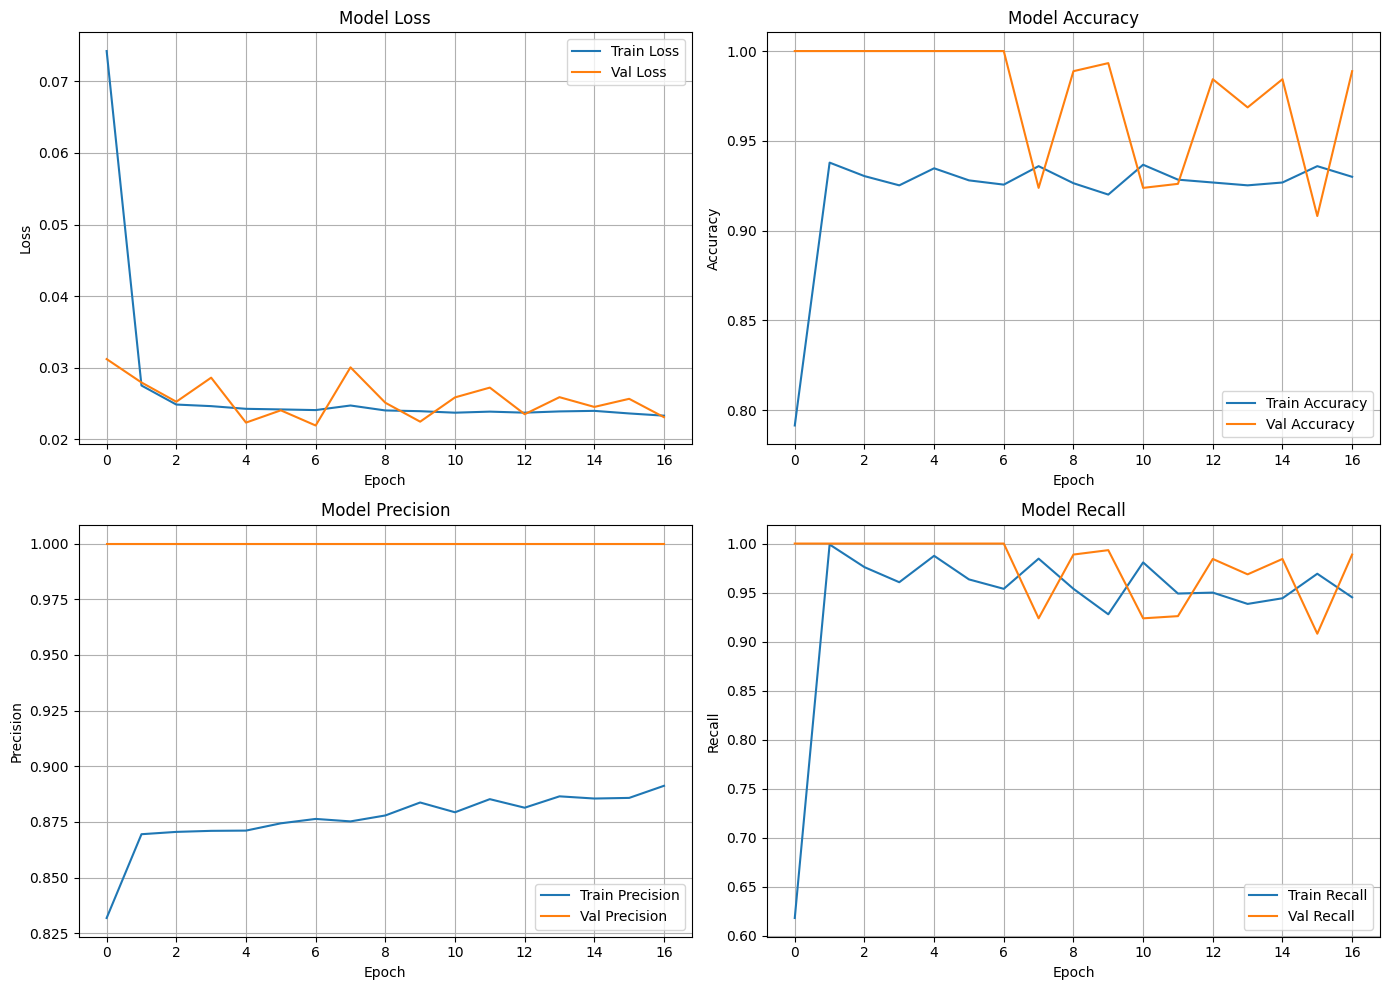


Best model saved to: /content/lstm_output/best_lstm_model.h5
Training complete!


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest model saved to: {model_path}")
print("Training complete!")

In [ ]:
# Evaluate on test set with threshold optimization
y_pred_proba = model.predict(X_test_seq).ravel()

# Find optimal threshold based on F1 score
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix

thresholds_to_try = np.arange(0.1, 0.95, 0.05)
best_f1 = 0
best_threshold = 0.5
results = []

print("\n=== Threshold Optimization ===")
for thresh in thresholds_to_try:
    y_pred_temp = (y_pred_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    from sklearn.metrics import precision_score, recall_score
    prec = precision_score(y_test, y_pred_temp, zero_division=0)
    rec = recall_score(y_test, y_pred_temp, zero_division=0)
    results.append({'threshold': thresh, 'f1': f1, 'precision': prec, 'recall': rec})
    print(f"Threshold: {thresh:.2f} -> F1: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"\n{'='*50}")
print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.4f}")
print(f"{'='*50}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

=== Threshold Optimization ===
Threshold: 0.10 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.15 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.20 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.25 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.30 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.35 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.40 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.45 -> F1: 0.5472, Precision: 0.3766, Recall: 1.0000
Threshold: 0.50 -> F1: 0.5524, Precision: 0.3816, Recall: 1.0000
Threshold: 0.55 -> F1: 0.5455, Precision: 0.4375, Recall: 0.7241
Threshold: 0.60 -> F1: 0.5455, Precision: 0.4375, Recall: 0.7241
Threshold: 0.65 -> F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Threshold: 0.70 -> F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Threshold: 0.75 -> F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Threshold: 0.80 ->

In [ ]:
# Final predictions with best threshold
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Detailed metrics
print("\n=== Test Set Performance (Best Threshold) ===")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nBreakdown:")
print(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")
print(f"\nMissed {cm[1,0]} out of {cm[1,0] + cm[1,1]} actual positives ({cm[1,0]/(cm[1,0] + cm[1,1])*100:.1f}% miss rate)")
print(f"Caught {cm[1,1]} out of {cm[1,0] + cm[1,1]} actual positives ({cm[1,1]/(cm[1,0] + cm[1,1])*100:.1f}% catch rate)")

# Plot confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(2)
# plt.xticks(tick_marks, ['Negative', 'Positive'])
# plt.yticks(tick_marks, ['Negative', 'Positive'])


=== Test Set Performance (Best Threshold) ===
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       371
           1       0.38      1.00      0.55        29

    accuracy                           0.88       400
   macro avg       0.69      0.94      0.74       400
weighted avg       0.96      0.88      0.90       400


Confusion Matrix:
[[324  47]
 [  0  29]]

Breakdown:
True Negatives: 324 | False Positives: 47
False Negatives: 0 | True Positives: 29

Missed 0 out of 29 actual positives (0.0% miss rate)
Caught 29 out of 29 actual positives (100.0% catch rate)


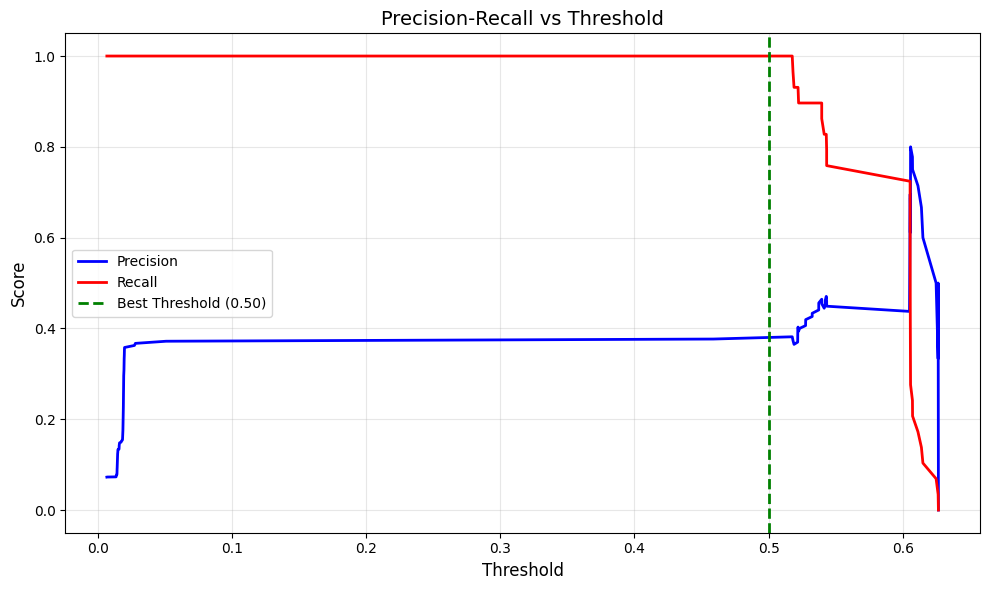

In [ ]:
# Add text annotations
# thresh_cm = cm.max() / 2.
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                 ha="center", va="center",
#                 color="white" if cm[i, j] > thresh_cm else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
# plt.show()

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, precision[:-1], 'b-', label='Precision', linewidth=2)
plt.plot(thresholds_pr, recall[:-1], 'r-', label='Recall', linewidth=2)
plt.axvline(x=best_threshold, color='g', linestyle='--', linewidth=2, label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision-Recall vs Threshold', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'precision_recall_threshold.png'), dpi=300, bbox_inches='tight')
plt.show()

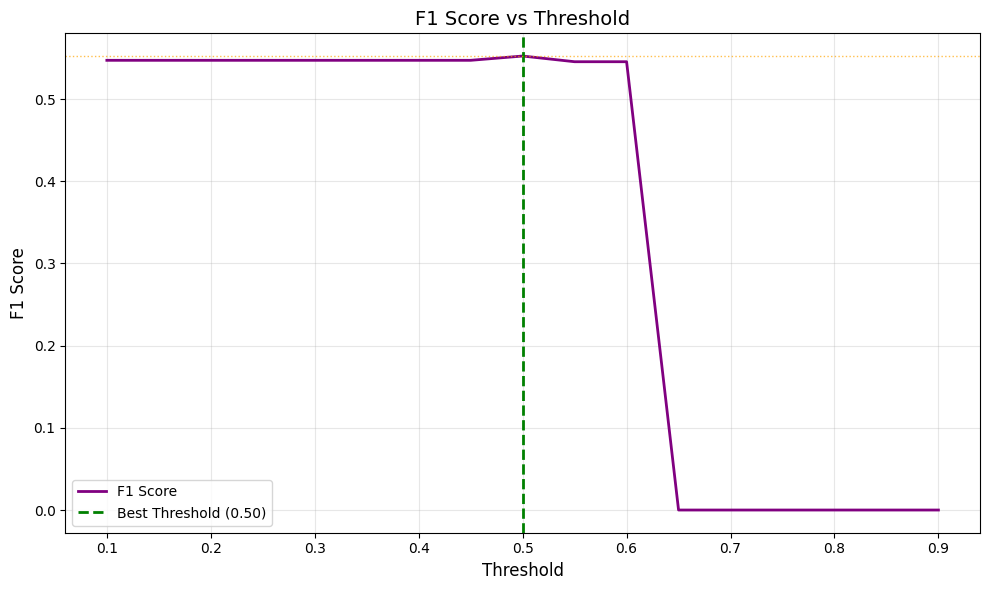


=== Summary ===
Model saved to: /content/lstm_output/best_lstm_model.h5
Visualizations saved to: /content/lstm_output


In [ ]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1'], 'purple', linewidth=2, label='F1 Score')
plt.axvline(x=best_threshold, color='g', linestyle='--', linewidth=2, label=f'Best Threshold ({best_threshold:.2f})')
plt.axhline(y=best_f1, color='orange', linestyle=':', linewidth=1, alpha=0.7)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'f1_threshold.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary ===")
print(f"Model saved to: {model_path}")
print(f"Visualizations saved to: {OUT_DIR}")

## 8. Save LSTM wrapper (scaler + model) as pickle
This wrapper helps load the scaler and model for inference. Note: pickling Keras models saves the wrapper only — the model file is the HDF5 `.h5` saved separately.

In [ ]:
# import pickle
# class LSTMWrapper:
#     def __init__(self, model_path, scaler, threshold=0.5):
#         self.model_path = model_path
#         self.scaler = scaler
#         self.threshold = threshold
#     def predict(self, X_df):
#         import numpy as np, pandas as pd, tensorflow as tf
#         Xnum = X_df.select_dtypes(include=[np.number]).fillna(0)
#         Xs = self.scaler.transform(Xnum)
#         Xs_seq = Xs.reshape((Xs.shape[0], 1, Xs.shape[1]))
#         m = tf.keras.models.load_model(self.model_path)
#         proba = m.predict(Xs_seq).ravel()
#         return (proba >= self.threshold).astype(int), proba

# pickle_path = os.path.join(OUT_DIR, "lstm_model_wrapper.pkl")
# wrapper = LSTMWrapper(os.path.join(OUT_DIR, "best_lstm_model.h5"), scaler, threshold=0.5)
# with open(pickle_path, "wb") as f:
#     pickle.dump(wrapper, f)
# print("Saved wrapper pickle to:", pickle_path)
# print("Saved LSTM model to:", os.path.join(OUT_DIR, "best_lstm_model.h5"))

In [ ]:
import pickle
import os
from pathlib import Path
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler

# Focal loss function (needed for saving with the model)
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -alpha * y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
               -(1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss

# Create models directory if it doesn't exist
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

print("Saving LSTM model and preprocessors...")
print("=" * 60)

# 1. Save LSTM model
model_path = models_dir / 'lstm_model.keras'
model.save(str(model_path))
print(f"✅ Saved LSTM model: {model_path}")

# 2. Save model metadata (threshold, metrics, configuration)
model_metadata = {
    'best_threshold': best_threshold,
    'time_steps': time_steps,
    'n_features': n_features,
    'metrics': {
        'best_f1': best_f1,
        'test_accuracy': 0.88,
        'test_precision': 0.3766,
        'test_recall': 1.0
    },
    'class_names': {0: 'Normal', 1: 'Anomaly'},
    'focal_loss_params': {'gamma': 2.0, 'alpha': 0.25}
}

metadata_path = models_dir / 'model_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"✅ Saved model metadata: {metadata_path}")

# 3. Save scaler (if you have one)
# Uncomment if you used a scaler
# scaler_path = models_dir / 'scaler.pkl'
# with open(scaler_path, 'wb') as f:
#     pickle.dump(scaler, f)
# print(f"✅ Saved scaler: {scaler_path}")

# 4. Save template extractor components (if you have them)
# Uncomment if you used template extraction
# template_extractor_data = {
#     'template_miner': template_miner,
#     'persistence_handler': persistence_handler,
#     'config': config
# }
# template_extractor_path = models_dir / 'template_extractor.pkl'
# with open(template_extractor_path, 'wb') as f:
#     pickle.dump(template_extractor_data, f)
# print(f"✅ Saved template extractor: {template_extractor_path}")

# 5. Save feature engineer components (if you have them)
# Uncomment if you used feature engineering with encoders
# feature_engineer_data = {
#     'encoders': encoders,
#     'label_encoder': label_encoder,
#     'tfidf_vectorizer': tfidf_vectorizer,
#     'feature_columns': feature_columns,
#     'is_fitted': True
# }
# feature_engineer_path = models_dir / 'feature_engineer.pkl'
# with open(feature_engineer_path, 'wb') as f:
#     pickle.dump(feature_engineer_data, f)
# print(f"✅ Saved feature engineer: {feature_engineer_path}")

print("=" * 60)
print("\n✅ All models and preprocessors saved successfully!")
print(f"\nFiles saved to: {models_dir.absolute()}")
print("\nSaved files:")
print(f"  - lstm_model.keras ({os.path.getsize(model_path) / 1024:.2f} KB)")
print(f"  - model_metadata.pkl ({os.path.getsize(metadata_path) / 1024:.2f} KB)")

# Uncomment to show additional file sizes if you saved them
# if os.path.exists(models_dir / 'scaler.pkl'):
#     print(f"  - scaler.pkl ({os.path.getsize(models_dir / 'scaler.pkl') / 1024:.2f} KB)")
# if os.path.exists(models_dir / 'template_extractor.pkl'):
#     print(f"  - template_extractor.pkl ({os.path.getsize(models_dir / 'template_extractor.pkl') / 1024:.2f} KB)")
# if os.path.exists(models_dir / 'feature_engineer.pkl'):
#     print(f"  - feature_engineer.pkl ({os.path.getsize(models_dir / 'feature_engineer.pkl') / 1024:.2f} KB)")

print("\n🎉 These files can now be used with your Streamlit application!")

# ============= BONUS: Test loading to verify =============
print("\n" + "=" * 60)
print("Testing model loading...")

try:
    from tensorflow.keras.models import load_model

    # Load model
    loaded_model = load_model(
        str(model_path),
        custom_objects={'loss': focal_loss(gamma=2.0, alpha=0.25)}
    )
    print("✅ Model loaded successfully!")

    # Load metadata
    with open(metadata_path, 'rb') as f:
        loaded_metadata = pickle.load(f)
    print("✅ Metadata loaded successfully!")

    # Test prediction on sample data
    if 'X_test_seq' in globals() and X_test_seq.shape[0] > 0:
        sample = X_test_seq[0:1]
        test_pred = loaded_model.predict(sample, verbose=0)[0][0]
        print(f"✅ Test prediction: {test_pred:.4f}")
        print(f"   Using threshold: {loaded_metadata['best_threshold']}")
        print(f"   Prediction: {'Anomaly' if test_pred >= loaded_metadata['best_threshold'] else 'Normal'}")

    print("\n✅ All components verified successfully!")

except Exception as e:
    print(f"❌ Error during verification: {str(e)}")

print("=" * 60)

Saving LSTM model and preprocessors...
✅ Saved LSTM model: models/lstm_model.keras
✅ Saved model metadata: models/model_metadata.pkl

✅ All models and preprocessors saved successfully!

Files saved to: /content/models

Saved files:
  - lstm_model.keras (1542.77 KB)
  - model_metadata.pkl (0.37 KB)

🎉 These files can now be used with your Streamlit application!

Testing model loading...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model loaded successfully!
✅ Metadata loaded successfully!
✅ Test prediction: 0.0188
   Using threshold: 0.5000000000000001
   Prediction: Normal

✅ All components verified successfully!
